Initial dataset setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/MyDrive/brats_data.zip /content/
!unzip /content/brats_data.zip
!mkdir Dataset002_AugmentedBRATS
!pip install SimpleITK

Mounted at /content/drive
Archive:  /content/brats_data.zip
   creating: archive_brain_mri_100/
   creating: archive_brain_mri_100/BraTS20_Training_001/
  inflating: archive_brain_mri_100/BraTS20_Training_001/BraTS20_Training_001_flair.nii  
  inflating: archive_brain_mri_100/BraTS20_Training_001/BraTS20_Training_001_seg.nii  
  inflating: archive_brain_mri_100/BraTS20_Training_001/BraTS20_Training_001_t1.nii  
  inflating: archive_brain_mri_100/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii  
  inflating: archive_brain_mri_100/BraTS20_Training_001/BraTS20_Training_001_t2.nii  
   creating: archive_brain_mri_100/BraTS20_Training_002/
  inflating: archive_brain_mri_100/BraTS20_Training_002/BraTS20_Training_002_flair.nii  
  inflating: archive_brain_mri_100/BraTS20_Training_002/BraTS20_Training_002_seg.nii  
  inflating: archive_brain_mri_100/BraTS20_Training_002/BraTS20_Training_002_t1.nii  
  inflating: archive_brain_mri_100/BraTS20_Training_002/BraTS20_Training_002_t1ce.nii  
  in

Convert from BraTS format to nnU-Net format

In [2]:
import os
import shutil
import nibabel as nib
import numpy as np

def convert_to_nnunet(source_dir, target_dir, training_ids, testing_ids):
    os.makedirs(os.path.join(target_dir, 'imagesTr'), exist_ok=True)
    os.makedirs(os.path.join(target_dir, 'imagesTs'), exist_ok=True)
    os.makedirs(os.path.join(target_dir, 'labelsTr'), exist_ok=True)

    modality_mapping = {'t1': '0000', 't2': '0001', 't1ce': '0002', 'flair': '0003'} # file name to layer

    def process_case(case_id, case_types): # train or test
        source_case_dir = os.path.join(source_dir, f'BraTS20_Training_{case_id}')

        for modality, layer in modality_mapping.items():
            source_file = os.path.join(source_case_dir, f'BraTS20_Training_{case_id}_{modality}.nii')

            for case_type in case_types:
                target_image_dir = os.path.join(target_dir, 'imagesTr' if case_type == 'train' else 'imagesTs')
                target_file = os.path.join(target_image_dir, f'BRATS_{case_id}_{layer}.nii.gz')

                img = nib.load(source_file)
                nib.save(img, target_file)

        if 'train' in case_types:
            source_seg_file = os.path.join(source_case_dir, f'BraTS20_Training_{case_id}_seg.nii')
            target_seg_file = os.path.join(target_dir, 'labelsTr', f'BRATS_{case_id}.nii.gz')

            seg_img = nib.load(source_seg_file)
            nib.save(seg_img, target_seg_file)

    all_ids = set(training_ids + testing_ids)
    for case_id in all_ids:
        case_types = []

        # test images are also used as 'validation' images in training split
        if case_id in training_ids:
            case_types.append('train')
        if case_id in testing_ids:
            case_types.append('test')
        process_case(case_id, case_types)

    print("Conversion completed successfully!")

# Usage
source_directory = 'archive_brain_mri_100'
target_directory = 'Dataset002_AugmentedBRATS'
# randomly generated but fixed for reproducability and model comparison
training_ids = ['010', '015', '086', '091', '016', '019', '066', '032', '084', '033', '057', '055', '036', '024', '056', '023', '040', '073', '051', '006', '041', '081', '045', '014', '058', '093', '074', '068', '099', '027', '065', '031', '008', '022', '078', '030', '072', '096', '095', '094','070', '052', '079', '050', '100', '071', '004', '089', '026', '007']
testing_ids = ['070', '052', '079', '050', '100', '071', '004', '089', '026', '007']

convert_to_nnunet(source_directory, target_directory, training_ids, testing_ids)

Conversion completed successfully!


Verify all files were copied

In [3]:
!ls -l /content/Dataset002_AugmentedBRATS/imagesTr | egrep -c '^-'
!ls -l /content/Dataset002_AugmentedBRATS/imagesTs | egrep -c '^-'
!ls -l /content/Dataset002_AugmentedBRATS/labelsTr | egrep -c '^-'


200
40
50


Re-do labeleing, must be consecutive for nnU-Net

In [4]:
import os
import nibabel as nib
import numpy as np


folder_path = '/content/Dataset002_AugmentedBRATS/labelsTr'

for filename in os.listdir(folder_path):
    if filename.endswith('.nii.gz'):
        file_path = os.path.join(folder_path, filename)

        img = nib.load(file_path)
        data = img.get_fdata()

        # replace all instances of 4 with 3 for nnunet
        data[data == 4] = 3

        new_img = nib.Nifti1Image(data, img.affine, img.header)

        # overwrite original image
        nib.save(new_img, file_path)

        print(f"Processed: {filename}")

print("All files processed")

Processed: BRATS_036.nii.gz
Processed: BRATS_095.nii.gz
Processed: BRATS_015.nii.gz
Processed: BRATS_057.nii.gz
Processed: BRATS_081.nii.gz
Processed: BRATS_072.nii.gz
Processed: BRATS_065.nii.gz
Processed: BRATS_019.nii.gz
Processed: BRATS_030.nii.gz
Processed: BRATS_074.nii.gz
Processed: BRATS_093.nii.gz
Processed: BRATS_068.nii.gz
Processed: BRATS_091.nii.gz
Processed: BRATS_100.nii.gz
Processed: BRATS_027.nii.gz
Processed: BRATS_007.nii.gz
Processed: BRATS_078.nii.gz
Processed: BRATS_014.nii.gz
Processed: BRATS_008.nii.gz
Processed: BRATS_006.nii.gz
Processed: BRATS_066.nii.gz
Processed: BRATS_079.nii.gz
Processed: BRATS_050.nii.gz
Processed: BRATS_089.nii.gz
Processed: BRATS_086.nii.gz
Processed: BRATS_099.nii.gz
Processed: BRATS_010.nii.gz
Processed: BRATS_033.nii.gz
Processed: BRATS_096.nii.gz
Processed: BRATS_055.nii.gz
Processed: BRATS_084.nii.gz
Processed: BRATS_031.nii.gz
Processed: BRATS_022.nii.gz
Processed: BRATS_051.nii.gz
Processed: BRATS_041.nii.gz
Processed: BRATS_070

Basic augmentation

In [6]:
import os
import random
import SimpleITK as sitk

# simple ITK flip method
def flip_nifti(file_path):
    image = sitk.ReadImage(file_path)
    flipped_image = sitk.Flip(image, [True, False, False])
    sitk.WriteImage(flipped_image, file_path)

images_dir = '/content/Dataset002_AugmentedBRATS/imagesTr'
labels_dir = '/content/Dataset002_AugmentedBRATS/labelsTr'

# get data IDs
patient_ids = set([f.split('_')[1] for f in os.listdir(images_dir) if f.endswith('.nii.gz')])

# select 20%
num_to_flip = int(len(patient_ids) * 0.2)
patients_to_flip = random.sample(list(patient_ids), num_to_flip)

print("Flipped examples:")
for patient_id in patients_to_flip:

    # flip images, all layers
    for i in range(4):
        img_file = f'BRATS_{patient_id}_{i:04d}.nii.gz'
        img_path = os.path.join(images_dir, img_file)
        flip_nifti(img_path)
        print(f"  - {img_file}")

    # flip segmentations
    label_file = f'BRATS_{patient_id}.nii.gz'
    label_path = os.path.join(labels_dir, label_file)
    flip_nifti(label_path)
    print(f"{label_file}")



Flipped examples:
  - BRATS_066_0000.nii.gz
  - BRATS_066_0001.nii.gz
  - BRATS_066_0002.nii.gz
  - BRATS_066_0003.nii.gz
BRATS_066.nii.gz
  - BRATS_026_0000.nii.gz
  - BRATS_026_0001.nii.gz
  - BRATS_026_0002.nii.gz
  - BRATS_026_0003.nii.gz
BRATS_026.nii.gz
  - BRATS_079_0000.nii.gz
  - BRATS_079_0001.nii.gz
  - BRATS_079_0002.nii.gz
  - BRATS_079_0003.nii.gz
BRATS_079.nii.gz
  - BRATS_007_0000.nii.gz
  - BRATS_007_0001.nii.gz
  - BRATS_007_0002.nii.gz
  - BRATS_007_0003.nii.gz
BRATS_007.nii.gz
  - BRATS_081_0000.nii.gz
  - BRATS_081_0001.nii.gz
  - BRATS_081_0002.nii.gz
  - BRATS_081_0003.nii.gz
BRATS_081.nii.gz
  - BRATS_096_0000.nii.gz
  - BRATS_096_0001.nii.gz
  - BRATS_096_0002.nii.gz
  - BRATS_096_0003.nii.gz
BRATS_096.nii.gz
  - BRATS_078_0000.nii.gz
  - BRATS_078_0001.nii.gz
  - BRATS_078_0002.nii.gz
  - BRATS_078_0003.nii.gz
BRATS_078.nii.gz
  - BRATS_095_0000.nii.gz
  - BRATS_095_0001.nii.gz
  - BRATS_095_0002.nii.gz
  - BRATS_095_0003.nii.gz
BRATS_095.nii.gz
  - BRATS_041_

Verify flipping was done in the correct direction

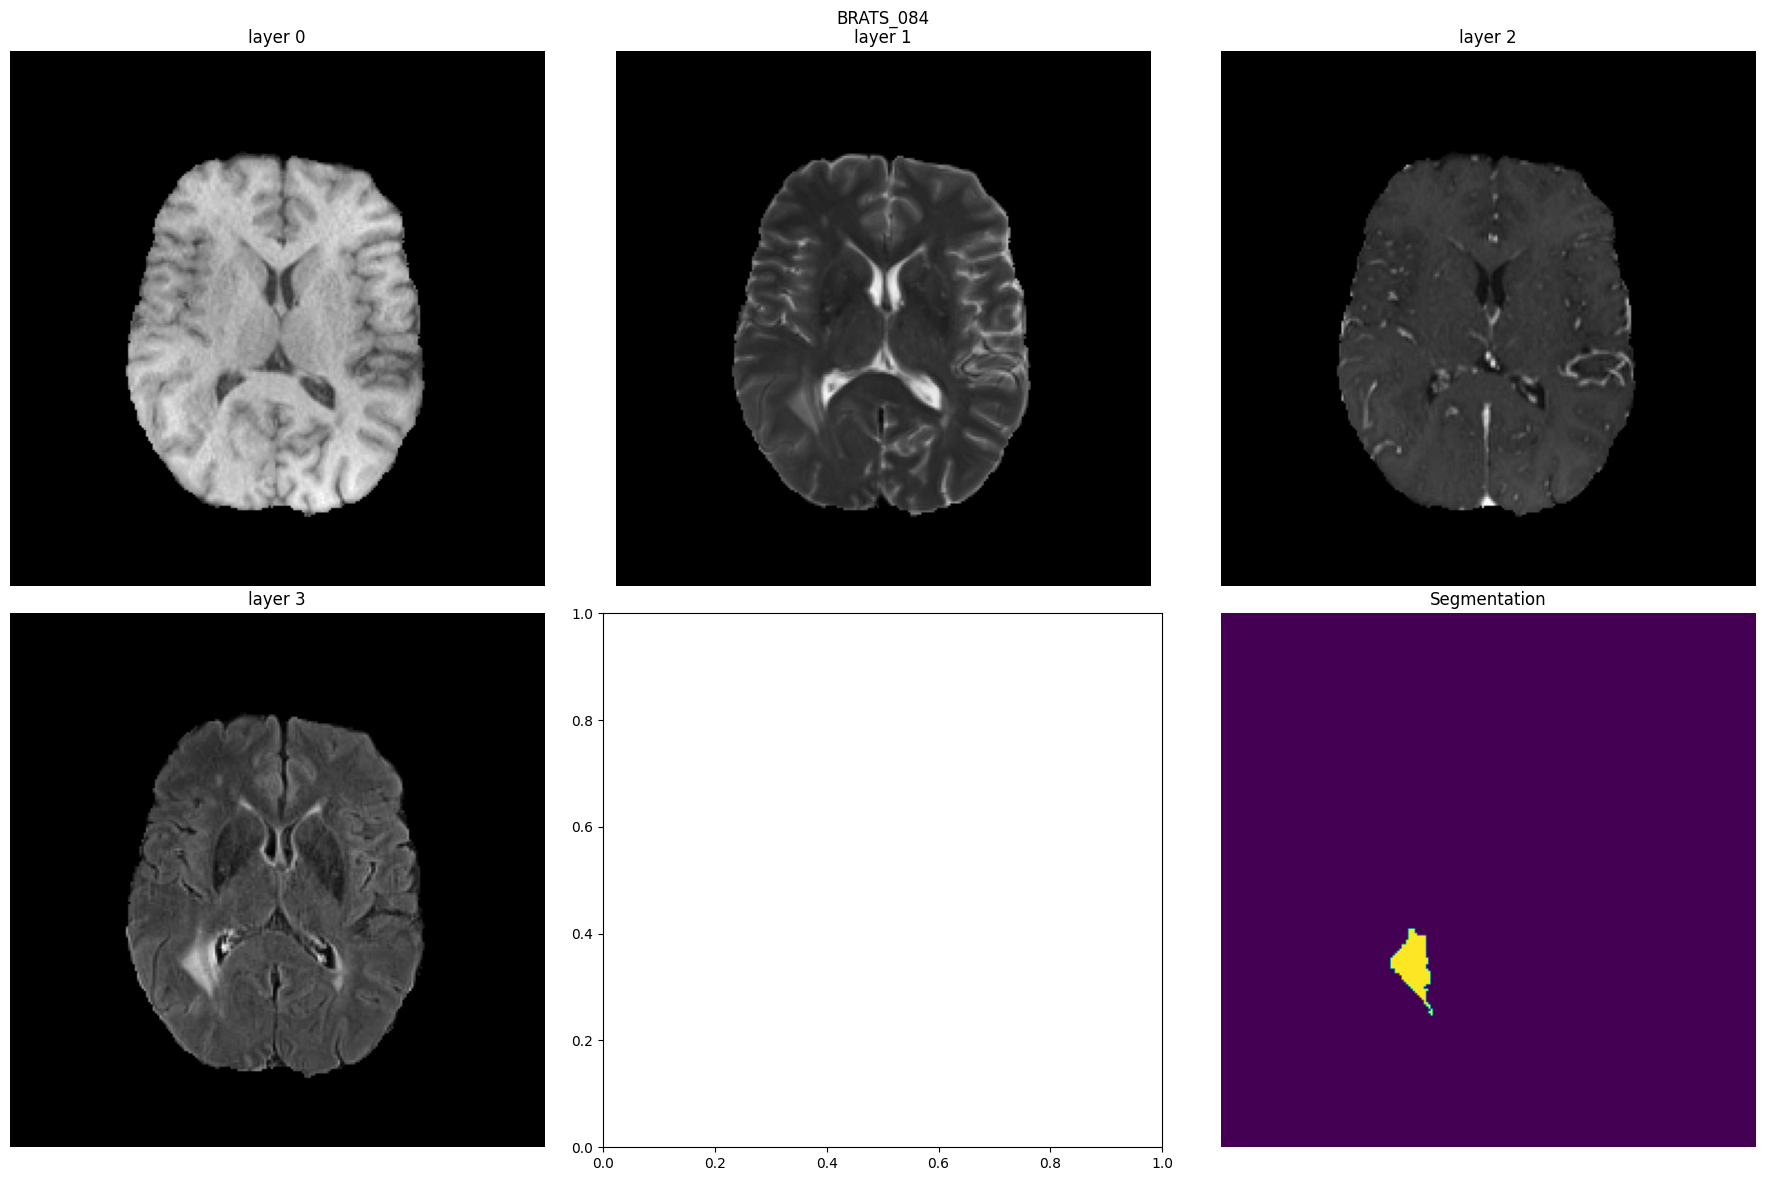

'Normalization is skipped because it is performed by nnUNet. BraTS images are already co-registered to a template and skull stripped.'

In [19]:
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np


# plot all the layers and segmentation to make sure they still match
def visualize_flipped_images_and_segmentation(patient_id):
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f"BRATS_{patient_id}")

    for i in range(4):
        img_file = f'BRATS_{patient_id}_{i:04d}.nii.gz'
        img_path = os.path.join(images_dir, img_file)

        image = sitk.ReadImage(img_path)
        array = sitk.GetArrayFromImage(image)

        mid_slice = array.shape[0] // 2
        axs[i // 3, i % 3].imshow(array[mid_slice], cmap='gray')
        axs[i // 3, i % 3].set_title(f'layer {i}')
        axs[i // 3, i % 3].axis('off')

    seg_file = f'BRATS_{patient_id}.nii.gz'
    seg_path = os.path.join(labels_dir, seg_file)

    seg_image = sitk.ReadImage(seg_path)
    seg_array = sitk.GetArrayFromImage(seg_image)

    mid_slice = seg_array.shape[0] // 2
    axs[1, 2].imshow(seg_array[mid_slice], cmap='viridis')
    axs[1, 2].set_title('Segmentation')
    axs[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

images_dir = '/content/Dataset002_AugmentedBRATS/imagesTr'
labels_dir = '/content/Dataset002_AugmentedBRATS/labelsTr'
patient_id = '084'
visualize_flipped_images_and_segmentation(patient_id)



'''Normalization is skipped because it is performed by nnUNet. BraTS images are already co-registered to a template and skull stripped.'''

Install nnU-Net

In [8]:
!git clone https://github.com/MIC-DKFZ/nnUNet.git
!cd /content/nnUNet && pip install -e .
!pip install triton
!pip install --upgrade git+https://github.com/FabianIsensee/hiddenlayer.git
!mkdir /content/nnUNet_raw
!mkdir /content/nnUNet_preprocessed
!mkdir /content/nnUNet_results
import os
os.environ['nnUNet_raw'] = '/content/nnUNet_raw'
os.environ['nnUNet_preprocessed'] = '/content/nnUNet_preprocessed'
os.environ['nnUNet_results'] = '/content/nnUNet_results'

Cloning into 'nnUNet'...
remote: Enumerating objects: 12876, done.
remote: Counting objects: 100% (159/159), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 12876 (delta 95), reused 128 (delta 89), pack-reused 12717 (from 1)
Receiving objects: 100% (12876/12876), 7.75 MiB | 17.99 MiB/s, done.
Resolving deltas: 100% (9857/9857), done.
Obtaining file:///content/nnUNet
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.4 MB/

Copy raw dataset, and download relevant dataset files

In [13]:
!cp -r /content/Dataset002_AugmentedBRATS /content/nnUNet_raw/
!cp /content/drive/MyDrive/dataset.json /content/nnUNet_raw/Dataset002_AugmentedBRATS/
!cp /content/drive/MyDrive/splits_final.json /content/nnUNet_raw/Dataset002_AugmentedBRATS/

Do dataset configuration

In [14]:
!nnUNetv2_plan_and_preprocess -d 002 --verify_dataset_integrity

Fingerprint extraction...
Dataset002_AugmentedBRATS
Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> reader/writer

####################
verify_dataset_integrity Done. 
If you didn't see any error messages then your dataset is most likely OK!
####################

Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> reader/writer
100% 50/50 [01:53<00:00,  2.28s/it]
Experiment planning...

############################
INFO: You are using the old nnU-Net default planner. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Dropping 3d_lowres config because the image size difference to 3d_fullres is too small. 3d_fullres: [140.  172.5 136. ], 3d_lowres: [140, 172, 136]
2D U-Net configuration:
{'data_identifier': 'nnUNetPlans_2d', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 105, 'patch_size': (192

nnU-Net training, use L4 or A100 GPUs

In [ ]:
!nnUNetv2_train 002 3d_fullres 1

Zip training results

In [ ]:
import os
import zipfile

directory_path = '/content/nnUNet_results/Dataset002_AugmentedBRATS'
output_filename = 'nnunet_augmented_results.zip'

with zipfile.ZipFile(output_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            zipf.write(os.path.join(root, file),
                       os.path.relpath(os.path.join(root, file),
                                       os.path.join(directory_path, '..')))

print(f"Directory '{directory_path}' has been zipped to '{output_filename}'")

Copy model and training results to drive

In [ ]:
!cp /content/nnunet_augmented_results.zip /content/drive/MyDrive

Create folder for inference, and run inference

In [ ]:
!mkdir nnunet_output
!nnUNetv2_predict -i /content/nnUNet_raw/Dataset002_AugmentedBRATS/imagesTs -o /content/nnunet_output -d 002 -c 3d_fullres -f 1

Zip inference results

In [ ]:
import os
import zipfile

directory_path = '/content/nnunet_output'
output_filename = 'inference_augmented_latest.zip'

with zipfile.ZipFile(output_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            zipf.write(os.path.join(root, file),
                       os.path.relpath(os.path.join(root, file),
                                       os.path.join(directory_path, '..')))

print(f"Directory '{directory_path}' has been zipped to '{output_filename}'")

Copy to Drive

In [ ]:
!cp /content/inference_augmented_latest.zip /content/drive/MyDrive